# MLP for "Pattern Matrix" Replacement

I followed this [tutorial](https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/) to implement the first iteration of the network.

## Summary of experiments
The following parameters were constant across all experiments:

|param|value|
|:-:|:-:|
|loss|BCELoss|
|optimizer|SGD with lr=0.001, momentum=0.9|
|model architecture| (inputs, 10), (10, 8)|
|activation (hidden)|ReLu|
|activation (output)|Sigmoid|

Two parameters namely, the size of the training set and the number of epochs were varied in a grid search and the optimal values were identified (ie. the point where validation and training losses converge). The results are summarised below.

|dataset|epochs|size (training)|accuracy|recall (related)|recall (unrelated)|
|:-:|:-:|:-:|:-:|:-:|:-:|
|train-slice-615-10-equal|10|9253|0.88|0.11|0.90|
|train-slice-615-25-equal|10|42407|0.94|0.44|0.96|
|train-slice-615-25-equal|25|42407|0.96|0.19|0.98|
|train-slice-615-50-equal|10|193898|0.95|0.42|0.96|
|train-slice-615-50-equal|5|193898|--|0.43|0.97|
|train-slice-615-50-equal-diff|5|193898|0.93|0.76|0.93|
|train-slice-615-50-equal-diff|2|193898|0.93|0.84|0.91|

The best model is obtained by using dataset train-slice-615-50-equal-diff which contains equal number of examples for each target and uses the difference between the points as the feature columns.

***NOTE the recall varies for each experiment due to random initialization of weights but in general it follows an error of +-5%.***

## Experiment 1
Use **scripts/train-slice-615-10-equal.csv** to generate the dataset.

### Parameters
- Data: 10% of slice 615 (equalized classes)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (8, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 10

### Remarks
The model is not able to classify the minority class well.

In [2]:
from context import km3net
from km3net.utils import DATADIR
import km3net.model.utils as model_utils
import km3net.model.eval as model_eval
import km3net.data.utils as data_utils
import km3net.model.data.pm as data_pm
from km3net.model.mlp import MLP
from torch.nn import BCELoss
from torch.optim import SGD
import torch
import pandas as pd

train size: 9253, valid size: 4557, test size: 364231
---
epochs: 0, train loss: 0.042, valid loss: 0.040
epochs: 1, train loss: 0.039, valid loss: 0.038
epochs: 2, train loss: 0.036, valid loss: 0.035
epochs: 3, train loss: 0.032, valid loss: 0.030
epochs: 4, train loss: 0.028, valid loss: 0.026
epochs: 5, train loss: 0.024, valid loss: 0.022
epochs: 6, train loss: 0.021, valid loss: 0.020
epochs: 7, train loss: 0.019, valid loss: 0.018
epochs: 8, train loss: 0.017, valid loss: 0.016
epochs: 9, train loss: 0.016, valid loss: 0.015
---


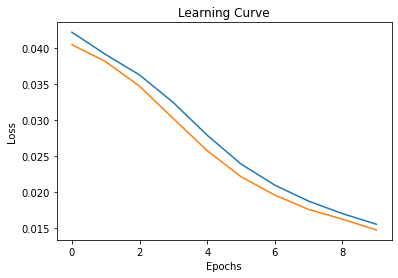

<Figure size 576x576 with 0 Axes>

Confusion matrix with normalization


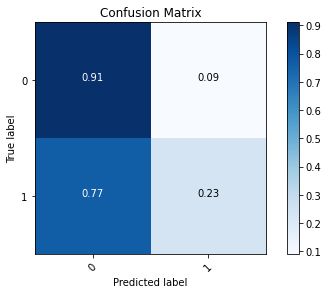

<Figure size 576x576 with 0 Axes>

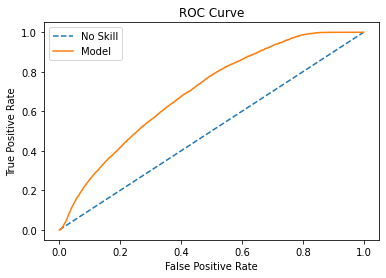

<Figure size 576x576 with 0 Axes>

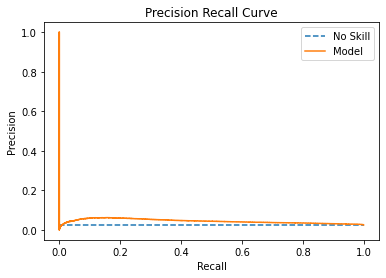

<Figure size 576x576 with 0 Axes>

Classification report:
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94    355859
         1.0       0.06      0.23      0.09      8372

    accuracy                           0.89    364231
   macro avg       0.52      0.57      0.52    364231
weighted avg       0.96      0.89      0.92    364231

ROC AUC: 0.698
Precision Recall AUC: 0.044
F1 Score: 0.093


In [4]:
train_path = DATADIR+'/train/slice-615-10-equal.csv'
test_path = DATADIR+'/test/slice-1637-10.csv'
train_dl, valid_dl = data_pm.prepare_train_data(train_path,normalise=True)
test_dl = data_pm.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(8).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 10,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl,
    'device': device
}

metrics = model_utils.evaluate(**params)
model_eval.evaluate(**metrics)

## Experiment 1.a
Next, we increase the size of training set whilst keeping the parameters the same.

### Parameters
- Data: 25% of slice 615 (equalized classes)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (8, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 10

### Remarks
The loss functions are now stable and seem to converge, the recall for related hits also improves.

train size: 42407, valid size: 20887, test size: 364231
---
epochs: 0, train loss: 0.035, valid loss: 0.028
epochs: 1, train loss: 0.023, valid loss: 0.018
epochs: 2, train loss: 0.016, valid loss: 0.013
epochs: 3, train loss: 0.012, valid loss: 0.010
epochs: 4, train loss: 0.009, valid loss: 0.008
epochs: 5, train loss: 0.008, valid loss: 0.007
epochs: 6, train loss: 0.007, valid loss: 0.006
epochs: 7, train loss: 0.006, valid loss: 0.006
epochs: 8, train loss: 0.006, valid loss: 0.006
epochs: 9, train loss: 0.005, valid loss: 0.005
---


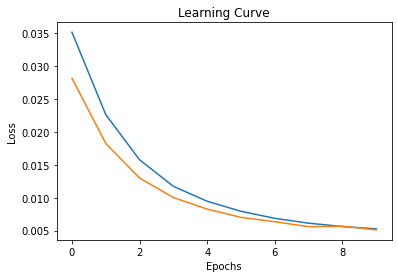

<Figure size 576x576 with 0 Axes>

Confusion matrix with normalization


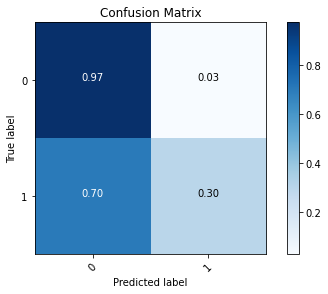

<Figure size 576x576 with 0 Axes>

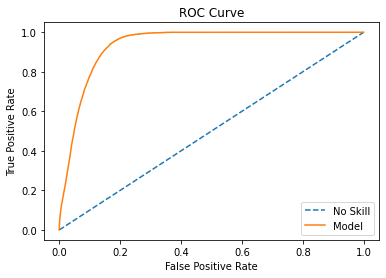

<Figure size 576x576 with 0 Axes>

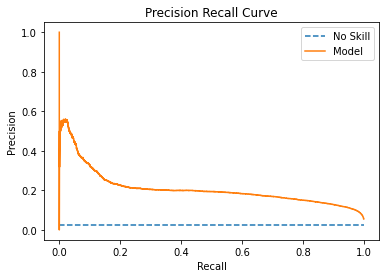

<Figure size 576x576 with 0 Axes>

Classification report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98    355859
         1.0       0.20      0.30      0.24      8372

    accuracy                           0.96    364231
   macro avg       0.59      0.64      0.61    364231
weighted avg       0.97      0.96      0.96    364231

ROC AUC: 0.936
Precision Recall AUC: 0.209
F1 Score: 0.243


In [5]:
train_path = DATADIR+'/train/slice-615-25-equal.csv'
test_path = DATADIR+'/test/slice-1637-10.csv'
train_dl, valid_dl = data_pm.prepare_train_data(train_path,normalise=True)
test_dl = data_pm.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(8).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 10,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl,
    'device': device
}

metrics = model_utils.evaluate(**params)
model_eval.evaluate(**metrics)

## Experiment 1.a.1
As an alternate path, we try increasing the training epochs to see if it helps the model.

### Remarks
Recall for related hits **decreases**, we can try with 12 epochs, but 10 seems to be a good number for this dataset. Also note that increasing the training size might require reducing the epochs for better results.

train size: 42407, valid size: 20887, test size: 364231
---
epochs: 0, train loss: 0.038, valid loss: 0.034
epochs: 1, train loss: 0.031, valid loss: 0.027
epochs: 2, train loss: 0.024, valid loss: 0.022
epochs: 3, train loss: 0.020, valid loss: 0.018
epochs: 4, train loss: 0.017, valid loss: 0.016
epochs: 5, train loss: 0.014, valid loss: 0.013
epochs: 6, train loss: 0.011, valid loss: 0.009
epochs: 7, train loss: 0.009, valid loss: 0.008
epochs: 8, train loss: 0.008, valid loss: 0.007
epochs: 9, train loss: 0.007, valid loss: 0.007
epochs: 10, train loss: 0.007, valid loss: 0.006
epochs: 11, train loss: 0.006, valid loss: 0.006
epochs: 12, train loss: 0.006, valid loss: 0.006
epochs: 13, train loss: 0.006, valid loss: 0.006
epochs: 14, train loss: 0.006, valid loss: 0.005
epochs: 15, train loss: 0.005, valid loss: 0.005
epochs: 16, train loss: 0.005, valid loss: 0.005
epochs: 17, train loss: 0.005, valid loss: 0.005
epochs: 18, train loss: 0.005, valid loss: 0.005
epochs: 19, train l

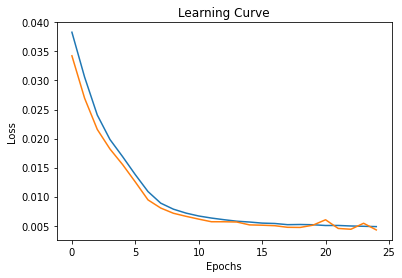

<Figure size 576x576 with 0 Axes>

Confusion matrix with normalization


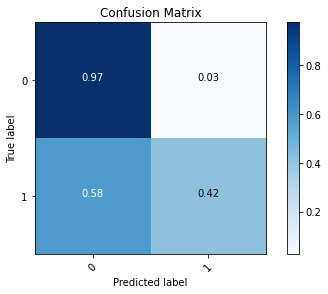

<Figure size 576x576 with 0 Axes>

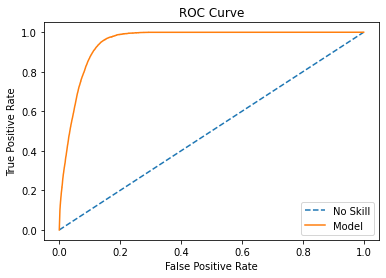

<Figure size 576x576 with 0 Axes>

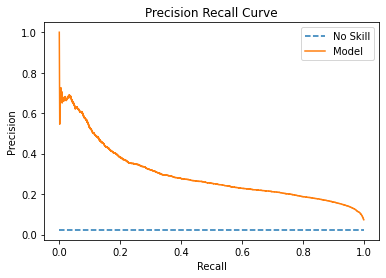

<Figure size 576x576 with 0 Axes>

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    355859
         1.0       0.27      0.42      0.33      8372

    accuracy                           0.96    364231
   macro avg       0.63      0.70      0.66    364231
weighted avg       0.97      0.96      0.97    364231

ROC AUC: 0.952
Precision Recall AUC: 0.296
F1 Score: 0.330


In [7]:
train_path = DATADIR+'/train/slice-615-25-equal.csv'
test_path = DATADIR+'/test/slice-1637-10.csv'
train_dl, valid_dl = data_pm.prepare_train_data(train_path,normalise=True)
test_dl = data_pm.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(8).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 25,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl,
    'device': device
}

metrics = model_utils.evaluate(**params)
model_eval.evaluate(**metrics)

## Experiment 1.b
Increase the size of training set to 50% of slice-615 whilst keeping the parameters the same.

### Parameters
- Data: 50% of slice 615 (equalized classes)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (8, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 10

### Remarks
The loss functions converge way before 10 epochs, and the recall for related hits is similar to exp.2, we can try early stopping.

train size: 193898, valid size: 95502, test size: 364231
---
epochs: 0, train loss: 0.021, valid loss: 0.011
epochs: 1, train loss: 0.008, valid loss: 0.007
epochs: 2, train loss: 0.006, valid loss: 0.006
epochs: 3, train loss: 0.006, valid loss: 0.005
epochs: 4, train loss: 0.006, valid loss: 0.006
epochs: 5, train loss: 0.005, valid loss: 0.005
epochs: 6, train loss: 0.005, valid loss: 0.005
epochs: 7, train loss: 0.005, valid loss: 0.005
epochs: 8, train loss: 0.005, valid loss: 0.005
epochs: 9, train loss: 0.005, valid loss: 0.005
---


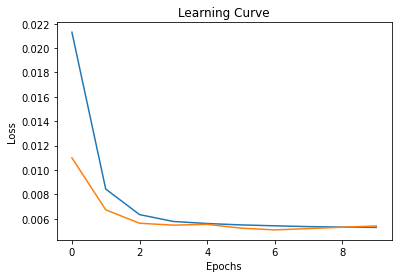

<Figure size 576x576 with 0 Axes>

Confusion matrix with normalization


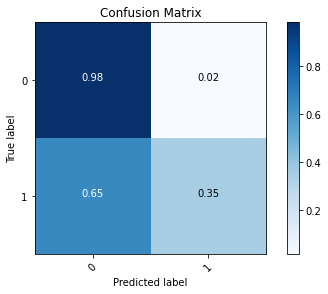

<Figure size 576x576 with 0 Axes>

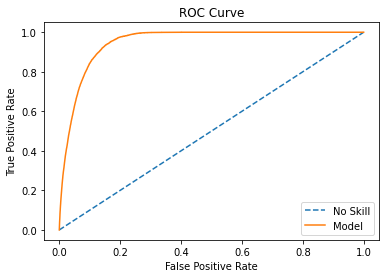

<Figure size 576x576 with 0 Axes>

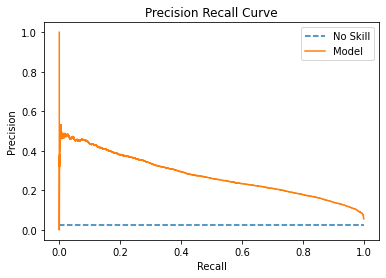

<Figure size 576x576 with 0 Axes>

Classification report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    355859
         1.0       0.32      0.35      0.33      8372

    accuracy                           0.97    364231
   macro avg       0.65      0.67      0.66    364231
weighted avg       0.97      0.97      0.97    364231

ROC AUC: 0.949
Precision Recall AUC: 0.276
F1 Score: 0.331


In [8]:
train_path = DATADIR+'/train/slice-615-50-equal.csv'
test_path = DATADIR+'/test/slice-1637-10.csv'
train_dl, valid_dl = data_pm.prepare_train_data(train_path,normalise=True)
test_dl = data_pm.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(8).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 10,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl,
    'device': device
}

metrics = model_utils.evaluate(**params)
model_eval.evaluate(**metrics)

## Experiment 1.b.1
With the increased training data, we do not need 10 epochs, from the learning curve of exp.3 we see that 5 seems to be a good place to stop.

### Parameters
- Data: 50% of slice 615 (equalized classes)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (8, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 5

### Remarks
From the learning curve it seems we can stop 1-2 epochs earlier but that may/may not result in any significant performance gain. It seems for the given parameters and model architecture we have acheived the best we can. Next, we try feature engineering.

train size: 193898, valid size: 95502, test size: 364231
---
epochs: 0, train loss: 0.020, valid loss: 0.009
epochs: 1, train loss: 0.007, valid loss: 0.007
epochs: 2, train loss: 0.006, valid loss: 0.006
epochs: 3, train loss: 0.006, valid loss: 0.005
epochs: 4, train loss: 0.006, valid loss: 0.005
---


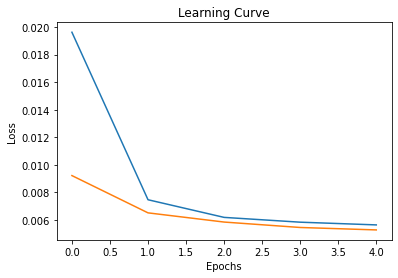

<Figure size 576x576 with 0 Axes>

Confusion matrix with normalization


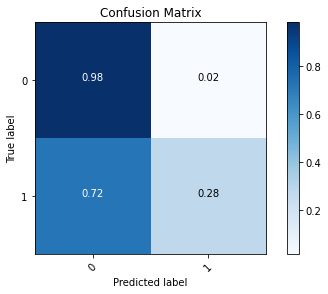

<Figure size 576x576 with 0 Axes>

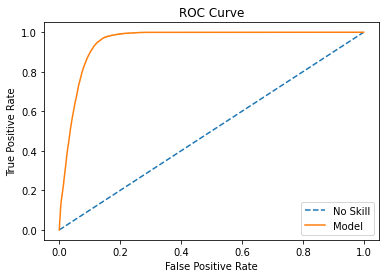

<Figure size 576x576 with 0 Axes>

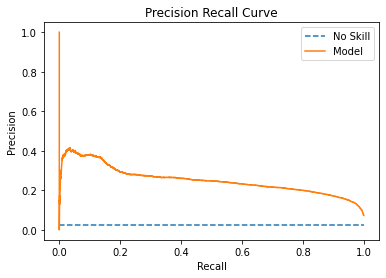

<Figure size 576x576 with 0 Axes>

Classification report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    355859
         1.0       0.27      0.28      0.28      8372

    accuracy                           0.97    364231
   macro avg       0.63      0.63      0.63    364231
weighted avg       0.97      0.97      0.97    364231

ROC AUC: 0.953
Precision Recall AUC: 0.252
F1 Score: 0.277


In [9]:
train_path = DATADIR+'/train/slice-615-50-equal.csv'
test_path = DATADIR+'/test/slice-1637-10.csv'
train_dl, valid_dl = data_pm.prepare_train_data(train_path,normalise=True)
test_dl = data_pm.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(8).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 5,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl,
    'device': device
}

metrics = model_utils.evaluate(**params)
model_eval.evaluate(**metrics)

## Experiment 2
We train the existing model with slice-615-50-equal-diff.csv which contains the difference of the points.

### Parameters
- Data: 50% of slice 615 (equalized classes, diff)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (4, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 5

### Remarks
The recall for related hits increases! From the learning curve it seems we can stop training even early.

train size: 193898, valid size: 95502, test size: 364231
---
epochs: 0, train loss: 0.027, valid loss: 0.014
epochs: 1, train loss: 0.012, valid loss: 0.010
epochs: 2, train loss: 0.009, valid loss: 0.009
epochs: 3, train loss: 0.009, valid loss: 0.009
epochs: 4, train loss: 0.009, valid loss: 0.010
epochs: 5, train loss: 0.009, valid loss: 0.009
epochs: 6, train loss: 0.009, valid loss: 0.009
epochs: 7, train loss: 0.009, valid loss: 0.009
epochs: 8, train loss: 0.008, valid loss: 0.009
epochs: 9, train loss: 0.008, valid loss: 0.008
---


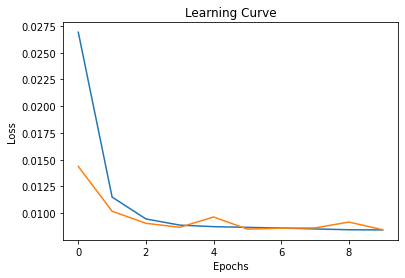

<Figure size 576x576 with 0 Axes>

Confusion matrix with normalization


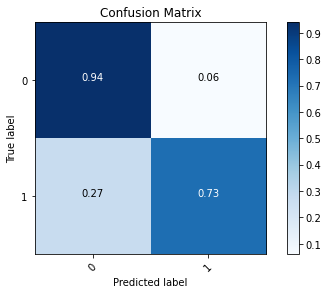

<Figure size 576x576 with 0 Axes>

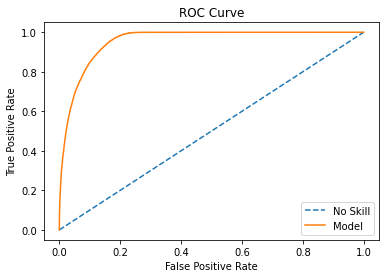

<Figure size 576x576 with 0 Axes>

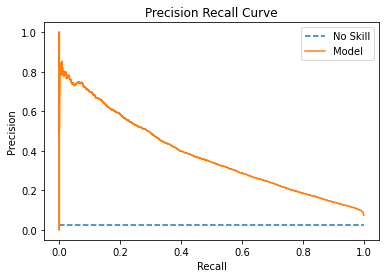

<Figure size 576x576 with 0 Axes>

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97    355859
         1.0       0.22      0.73      0.34      8372

    accuracy                           0.93    364231
   macro avg       0.61      0.83      0.65    364231
weighted avg       0.98      0.93      0.95    364231

ROC AUC: 0.955
Precision Recall AUC: 0.381
F1 Score: 0.339


In [11]:
train_path = DATADIR+'/train/slice-615-50-equal-diff.csv'
test_path = DATADIR+'/test/slice-1637-10-diff.csv'
train_dl, valid_dl = data_pm.prepare_train_data(train_path,normalise=True)
test_dl = data_pm.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(4).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 10,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl,
    'device': device
}

metrics = model_utils.evaluate(**params)
model_eval.evaluate(**metrics)

## Experiment 2.a
Increase training data to 75% of slice 615, epochs varied to find best model.

### Parameters
- Data: 75% of slice 615 (equalized classes, diff)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (4, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 10

### Remarks
TODO

train size: 407162, valid size: 200542, test size: 364231
---
epochs: 0, train loss: 0.025, valid loss: 0.011
epochs: 1, train loss: 0.009, valid loss: 0.009
epochs: 2, train loss: 0.009, valid loss: 0.008
epochs: 3, train loss: 0.009, valid loss: 0.008
epochs: 4, train loss: 0.009, valid loss: 0.009
epochs: 5, train loss: 0.009, valid loss: 0.009
epochs: 6, train loss: 0.009, valid loss: 0.009
epochs: 7, train loss: 0.009, valid loss: 0.009
epochs: 8, train loss: 0.008, valid loss: 0.008
epochs: 9, train loss: 0.008, valid loss: 0.008
---


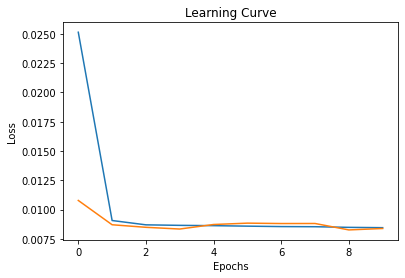

<Figure size 576x576 with 0 Axes>

Confusion matrix with normalization


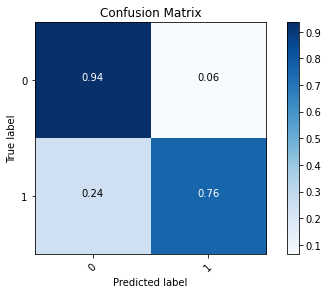

<Figure size 576x576 with 0 Axes>

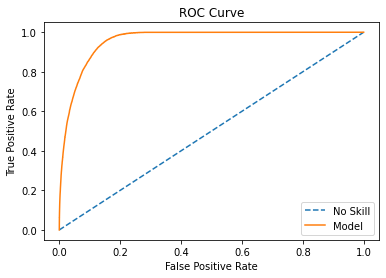

<Figure size 576x576 with 0 Axes>

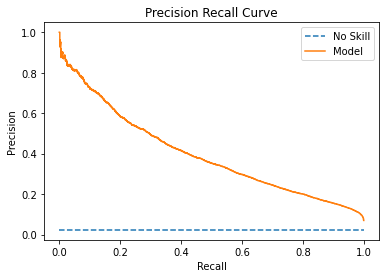

<Figure size 576x576 with 0 Axes>

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96    355859
         1.0       0.22      0.76      0.34      8372

    accuracy                           0.93    364231
   macro avg       0.61      0.85      0.65    364231
weighted avg       0.98      0.93      0.95    364231

ROC AUC: 0.958
Precision Recall AUC: 0.397
F1 Score: 0.337


In [12]:
train_path = DATADIR+'/train/slice-615-75-equal-diff.csv'
test_path = DATADIR+'/test/slice-1637-10-diff.csv'
train_dl, valid_dl = data_pm.prepare_train_data(train_path,normalise=True)
test_dl = data_pm.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(4).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 10,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl,
    'device': device
}

metrics = model_utils.evaluate(**params)
model_eval.evaluate(**metrics)

In [14]:
import sklearn.metrics as skmet

In [22]:
y_true, y_pred = metrics['y_true'], metrics['y_pred']

In [30]:
tp, fp, fn, tp = skmet.confusion_matrix(y_true, y_pred).ravel()

In [24]:
cm = skmet.confusion_matrix(y_true, y_pred, normalize='true')
cm

array([[0.93554751, 0.06445249],
       [0.24283325, 0.75716675]])

In [27]:
acc = skmet.accuracy_score(y_true, y_pred)
acc

0.9314473507197355

In [29]:
bacc = skmet.balanced_accuracy_score(y_true, y_pred)
bacc

0.8463571262361897

In [31]:
recall = tp + (tp + fp)
recall

35614

In [32]:
skmet.precision_recall_fscore_support(y_true, y_pred, average='weighted')

(0.9760617395520718, 0.9314473507197355, 0.9494416788069593, None)

In [34]:
skmet.precision_recall_fscore_support(y_true, y_pred, average='binary')

(0.216532877882152, 0.7571667462971811, 0.33675990118734556, None)